# Приоритизация гипотез и анализ A/B-теста для интернет-магазина

Мы помогаем с аналитикой крупному интернет-магазину. Вместе с отделом маркетинга мы подготовили список гипотез для увеличения выручки.

Нам надо приоритизировать гипотезы, запустить A/B-тест для одной из них и проанализировать результаты.

## Содержание<a name="Содержание"></a>

1. [Приоритизация гипотез](#1.-Приоритизация-гипотез)
2. [Знакомство с данными по A/B-тесту](#2.-Знакомство-с-данными-по-A/B-тесту)
	1. [Посетители](#Посетители)
	2. [Заказы](#Заказы)
3. [Предобработка данных](#3.-Предобработка-данных)
	1. [Переименование столбцов orders](#Переименование-столбцов-orders)
	2. [Замена типа данных](#Замена-типа-данных)
	3. [Поиск дубликатов](#Поиск-дубликатов)
	4. [Пользователи, попавшие в обе группы](#Пользователи,-попавшие-в-обе-группы)
	5. [Равенство размеров групп](#Равенство-размеров-групп)
	6. [Вывод](#Вывод)
4. [Анализ A/B-теста по кумулятивным метрикам](#4.-Анализ-A/B-теста-по-кумулятивным-метрикам)
	1. [Графики среднего чека и конверсии](#Графики-среднего-чека-и-конверсии)
	2. [Количество заказов по пользователям](#Количество-заказов-по-пользователям)
	3. [Количество заказов по стоимости](#Количество-заказов-по-стоимости)
	4. [Избавление от выбросов](#Избавление-от-выбросов)
	5. [Графики среднего чека и конверсии по очищенным данным](#Графики-среднего-чека-и-конверсии-по-очищенным-данным)
	6. [Расчет статзначимости различий](#Расчет-статзначимости-различий)
5. [Выводы по результатам теста](#5.-Выводы-по-результатам-теста)

## 0. Импорт библиотек

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats as st
from statsmodels.stats.proportion import proportions_ztest

In [2]:
pd.set_option('max_colwidth', None)
sns.set_style('darkgrid')

## 1. Приоритизация гипотез<a name="1.-Приоритизация-гипотез"></a>

### Знакомство с данными

Познакомимся с таблицей гипотез. Сохраним ее в переменную `hypothesis` и выведем на экран.

In [3]:
hypothesis = pd.read_csv('hypothesis.csv')
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


Каждый объект в `hypothesis` — это информация о гипотезе по увеличению выручки интернет-магазина. Известно:

- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Здесь не нужна предобработка, поэтому сразу перейдем к приоритезации гипотез.

### Приоритезация гипотез по ICE 

У метода приоритезации ICE следующая формула:

$$ ICE⠀score = {{Impact × Confidence}\over{Efforts}} $$

Чем значение ICE выше, тем важнее гипотеза.

Рассчитаем ICE для наших гипотез и сохраним их в новый столбец `ICE`. Выведем отсортированные по ICE гипотезы.

In [4]:
hypothesis['ICE'] = hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts']
hypothesis[['Hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)

,Hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


### Приоритезация гипотез по RICE

Метод RICE похож на ICE, но помимо влияния на пользователей, уверенности в результате и затрат учитывает еще и скольких пользователей затронет изменение. RICE рассчитывается по такой формуле:

$$ RICE⠀score = {{Reach × Impact × Confidence}\over{Efforts}} $$

Найдем RICE для каждой гипотезы и сохраним их в новый столбец RICE. Выведем отсортированные по RICE гипотезы.

In [5]:
hypothesis['RICE'] = hypothesis['Reach'] * hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts']
hypothesis[['Hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)

,Hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


### Вывод

Посмотрим на всю таблицу и сравним RICE и ICE.

In [6]:
hypothesis.sort_values(by='RICE', ascending=False)

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000,3.0


Топ-5 акций по ICE и RICE совпали по содержанию, но не по позициям. Охват сильно перемешал гипотезы в топе.

Например, первая по ICE гипотеза о скидке в день рождения оказалось последней по RICE в топ-5 гипотез. Так получилась из-за того, что ее охват равен единице. Это самый маленький показатель из всех гипотез. Скорее всего, небольшой охват связан с тем, что малое количество покупателей делятся информацией о своем дне рождения. Поэтому мы не сможем сделать им праздничное предложение.

Несмотря на то, что по наибольший коэффициент RICE у гипотезы о добавлении формы подписки на email-рассылку на основные страницы, она не подходит для A/B-теста. Поэтому возьмем гипотезу со вторым по величине коэффициентом.

Будем считать, что в последующем А/В тесте мы проверяли гипотезу о влиянии наличия блока рекомендаций товаров на конверсию и средний чек.

[К содержанию](#Содержание)

## 2. Знакомство с данными по A/B-тесту<a name="2.-Знакомство-с-данными-по-A/B-тесту"></a>

Мы добавили на сайт блок рекомендаций, провели A/B-тест и получили результаты, которые описаны в файлах `orders.csv` и `visitors.csv`. Сохраним их в переменные `orders` и `visitors` и посмотрим на общую информацию.

In [7]:
orders = pd.read_csv('orders.csv')
visitors = pd.read_csv('visitors.csv')

In [8]:
def show_stats(df, title=''):
    print('\033[1m' + title + '\033[0m')
    display(df)
    print(df.info())
    print(df.describe())

### Посетители<a name="Посетители"></a>

В `visitots` хранятся данные о количестве посетителей. Каждая строчка содержит:

- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста.

In [9]:
show_stats(visitors)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
None
         visitors
count   62.000000
mean   607.290323
std    114.400560
min    361.000000
25%    534.000000
50%    624.500000
75%    710.500000
max    770.000000


**Наблюдения**

1. Эксперимент проводили с 1 по 31 августа 2019 года.
2. У столбца `date` неправильный типа данных `object`. Должен быть `datetime`.
3. Размерность столбца `visitors` можно понизить.

### Заказы<a name="Заказы"></a>

`orders` содержит информацию о заказах. А именно:

- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

In [10]:
show_stats(orders)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
None
       transactionId     visitorId       revenue
count   1.197000e+03  1.197000e+03  1.197000e+03
mean    2.155621e+09  2.165960e+09  8.348006e+03
std     1.229085e+09  1.236014e+09  3.919113e+04
min     1.062393e+06  5.114589e+06  5.000000e+01
25%     1.166776e+09  1.111826e+09  1.220000e+03
50%     2.145194e+09  2.217985e+09  2.978000e+03
75%     3.237740e+09  3.177606e+09  8.290000e+03
max     4.293856e+09  4.283872e+09  1.294500e+06


**Наблюдения**

1. Идентификаторы заказа и пользователя не очень удобно названы. Переименуем их, чтобы в названиях столбцов не было заглавных букв.
2. У столбца `date` неправильный типа данных `object`. Должен быть `datetime`.
3. Размерность столбца `revenue` можно понизить, чтобы уменьшить размер датафрейма.

[К содержанию](#Содержание)

## 3. Предобработка данных<a name="3.-Предобработка-данных"></a>

### Переименование столбцов orders<a name="Переименование-столбцов-orders"></a>

Переименуем столбцы датафрейма `orders` и посмотрим на результат.

In [11]:
orders = orders.rename(columns={
    'transactionId': 'transaction_id',
    'visitorId': 'visitor_id'
})

orders.columns

Index(['transaction_id', 'visitor_id', 'date', 'revenue', 'group'], dtype='object')

### Замена типа данных<a name="Замена-типа-данных"></a>

Сначала исправим столбцы с датами. Для этого воспользуемся методом `to_datetime` из `pandas`.

In [12]:
visitors['date'] = pd.to_datetime(visitors['date'])
orders['date'] = pd.to_datetime(orders['date'])

Теперь понизим размерность численных столбцов с помощью метода `to_numeric` с параметром `downcast`. Так у численных столбцов будут минимальные размерности с учетом их содержимого.

In [13]:
visitors['visitors'] = pd.to_numeric(visitors['visitors'], downcast='unsigned')
orders['revenue'] = pd.to_numeric(orders['revenue'], downcast='unsigned')

Посмотрим на результат замен.

In [14]:
print('\033[1m' + 'Посетители' + '\033[0m')
visitors.info()

Посетители
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     uint16        
dtypes: datetime64[ns](1), object(1), uint16(1)
memory usage: 1.2+ KB


In [15]:
print('\033[1m' + 'Заказы' + '\033[0m')
orders.info()

Заказы
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1197 non-null   int64         
 1   visitor_id      1197 non-null   int64         
 2   date            1197 non-null   datetime64[ns]
 3   revenue         1197 non-null   uint32        
 4   group           1197 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(1), uint32(1)
memory usage: 42.2+ KB


### Поиск дубликатов<a name="Поиск-дубликатов"></a>

Нам повезло: в датафреймах нет строковых переменных c большим количеством вариантов значений, поэтому нам не надо обрабатывать их перед проверкой. В столбцах `group` всего два уникальных значения: A и B.

Применим к таблицам метод `duplicated()`, который каждой повторяющейся строке, кроме первого экземпляра, ставит True. Подсчитаем количество таких True методом `sum()`.

In [16]:
print('\033[1m' + 'Число дубликатов' + '\033[0m')
print('Посетители:', visitors.duplicated().sum())
print('Заказы:', orders.duplicated().sum())

Число дубликатов
Посетители: 0
Заказы: 0


В датафреймах нет дубликатов, ура!

### Пользователи, попавшие в обе группы<a name="Пользователи,-попавшие-в-обе-группы"></a>

К сожалению, у нас нет id посетителей из каждой группы. Есть только количество пользователей по дням. 

In [17]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


Поэтому мы не можем проверить, были ли посетители, которые попали и в контрольную, и в тестовую группы.

Зато в `orders` есть id покупателей. Поэтому мы можем посмотреть, есть ли покупатели, записанные в обе группы. Сделаем это.

In [18]:
flickers = (orders
            .groupby('visitor_id', as_index=False)
            .agg({'group':'nunique'})
            .query('group>1'))
flickers.head()

,visitor_id,group
2,8300375,2
44,199603092,2
51,232979603,2
55,237748145,2
66,276558944,2


Покупатели, попавшие в обе группы, есть. Посчитаем, сколько их и какую долю от всех покупателей они составляют.

In [19]:
n_flickers = len(flickers)
n_buyers = orders['visitor_id'].nunique()
flickers_share = n_flickers / n_buyers

In [20]:
print('\033[1m' + 'Покупатели, попавшие в обе группы' + '\033[0m')
print(f'Число: {n_flickers}')
print(f'Процент от всех покупателей {flickers_share:.2%}')

Покупатели, попавшие в обе группы
Число: 58
Процент от всех покупателей 5.63%


Меньше 6% покупателей попали в обе группы. Мы можем пожертвовать таким объемом данных ради более корректных выводов из теста.

Удалим «бегунков».

In [21]:
flickers_ids = flickers['visitor_id'].values
flickers_ids[:5]

array([  8300375, 199603092, 232979603, 237748145, 276558944])

In [22]:
orders = orders.query('visitor_id not in @flickers_ids')

Проверим, что пользователей, попавших в обе группы, больше нет.

In [23]:
flickers = (orders
            .groupby('visitor_id', as_index=False)
            .agg({'group':'nunique'})
            .query('group>1'))
flickers.head()

,visitor_id,group


### Равенство размеров групп<a name="Равенство-размеров-групп"></a>

Разные размеры контрольной и тестовой групп искажают результаты. Удостоверимся, что они равны.

In [24]:
n_visitors_a = visitors.query('group == "A"')['visitors'].sum()
n_visitors_b = visitors.query('group == "B"')['visitors'].sum()
visitors_b_to_a = n_visitors_b / n_visitors_a

In [25]:
print('Число посетителей по группам')
print('Группа A:', n_visitors_a)
print('Группа B:', n_visitors_b)
print(f'Отношение размера B к A: {visitors_b_to_a:.5}')

Число посетителей по группам
Группа A: 18736
Группа B: 18916
Отношение размера B к A: 1.0096


Разница в размерах групп составляет меньше 1%. Такое качество нам подходит.

### Вывод

Мы познакомились с данными и исправили несколько проблем в них:

- поменяли названия столбцов `orders` на более удобные,
- заменили типы данных: даты вместо `object` стали `datetime`, а у чисел уменьшилась размерность, из-за чего таблицы стали меньше весить;
- удалили покупателей, которые попали и в контрольную, и в тестовую группы;
- убедились, что размеры тестовой и контрольной групп равны.

Можно переходить к анализу.

[К содержанию](#Содержание)

## 4. Анализ A/B-теста по кумулятивным метрикам<a name="4.-Анализ-A/B-теста-по-кумулятивным-метрикам"></a>

### Графики среднего чека и конверсии<a name="Графики-среднего-чека-и-конверсии"></a>

#### Кумулятивная выручка по группам

Построим график кумулятивной выручки по группам. Для этого сначала нужно собрать кумулятивные данные. Объявим датафрейм `cumulativeData` со столбцами:
- date — дата;
- group — группа A/B-теста (A или B);
- orders — кумулятивное количество заказов на указанную дату в указанной группе;
- buyers — кумулятивное количество пользователей, совершивших хотя бы один заказ, на указанную дату в указанной группе;
- revenue — кумулятивная выручка на указанную дату в указанной группе;
- visitors — кумулятивное количество посетителей интернет-магазина на указанную дату в определённой группе.

Соберем `cumulativeData` в несколько этапов. Сначала создадим массив уникальных пар *дата, группа* методом `drop_duplicates()`.

In [26]:
datesGroups = orders[['date','group']].drop_duplicates(ignore_index=True)
datesGroups.head()

,date,group
0,2019-08-15,B
1,2019-08-15,A
2,2019-08-16,A
3,2019-08-16,B
4,2019-08-01,A


Теперь получим кумулятивные данные для заказов. Для этого напишем функцию, которая для каждой строки `datesGroups` будет рассчитывать кумулятивное количество транзакций, покупателей и выручки.

In [27]:
def get_cumulative_orders_data(row):
    date = row[0] # дата в datesGroups
    group = row[1] # группа в datesGroups
    
    # Выбираем из orders заказы, которые посетители из нужной группы group совершали до даты date (включительно)
    orders_filtered = orders[np.logical_and(
        orders['date'] <= date,
        orders['group'] == group)]
    
    orders_agg = orders_filtered.agg({
        'date': 'max', # Выбираем самую позднюю дату. Она будет равна дате в datesGroups, которая хранится в date.
        'group': 'max', # Тут могла быть любая функция. Нам просто нужно, чтобы группа не пропала из итогового вывода.
        'transaction_id': 'nunique', 
        'visitor_id': 'nunique',
        'revenue' : 'sum'})
    
    return orders_agg

In [28]:
ordersAggregated = (datesGroups
                    .apply(axis=1, func=get_cumulative_orders_data)
                    .sort_values(by=['date','group']))

ordersAggregated.head()

,date,group,transaction_id,visitor_id,revenue
4,2019-08-01,A,23,19,142779
5,2019-08-01,B,17,17,59758
12,2019-08-02,A,42,36,234381
11,2019-08-02,B,40,39,221801
17,2019-08-03,A,66,60,346854


Аналогично получим агрегированные кумулятивные по дням данные о посетителях интернет-магазина:

In [29]:
def get_cumulative_visitors_data(row):
    date = row[0] 
    group = row[1]
    
    visitors_filtered = visitors[np.logical_and(
        visitors['date'] <= date,
        visitors['group'] == group)]
    
    visitors_agg = visitors_filtered.agg({
        'date': 'max',
        'group': 'max',
        'visitors' : 'sum'})
    
    return visitors_agg

In [30]:
visitorsAggregated = (datesGroups
                      .apply(axis=1, func=get_cumulative_visitors_data)
                      .sort_values(by=['date','group']))

visitorsAggregated.head()

,date,group,visitors
4,2019-08-01,A,719
5,2019-08-01,B,713
12,2019-08-02,A,1338
11,2019-08-02,B,1294
17,2019-08-03,A,1845


Объединим обе таблицы в одной с понятными названиями столбцов:

In [31]:
cumulativeData = ordersAggregated.merge(visitorsAggregated,
                                        left_on=['date', 'group'],
                                        right_on=['date', 'group'])

cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
cumulativeData.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


Создадим датафреймы с кумулятивным количеством заказов и кумулятивной выручкой по дням в группах A и B.

In [32]:
cumulativeRevenueA = cumulativeData.query('group == "A"')[['date','revenue', 'orders']]
cumulativeRevenueB = cumulativeData.query('group == "B"')[['date','revenue', 'orders']]

cumulativeRevenueA.head()

,date,revenue,orders
0,2019-08-01,142779,23
2,2019-08-02,234381,42
4,2019-08-03,346854,66
6,2019-08-04,388030,77
8,2019-08-05,474413,99


Наконец построим графики кумулятивной выручки по дням и группам A/B-тестирования.

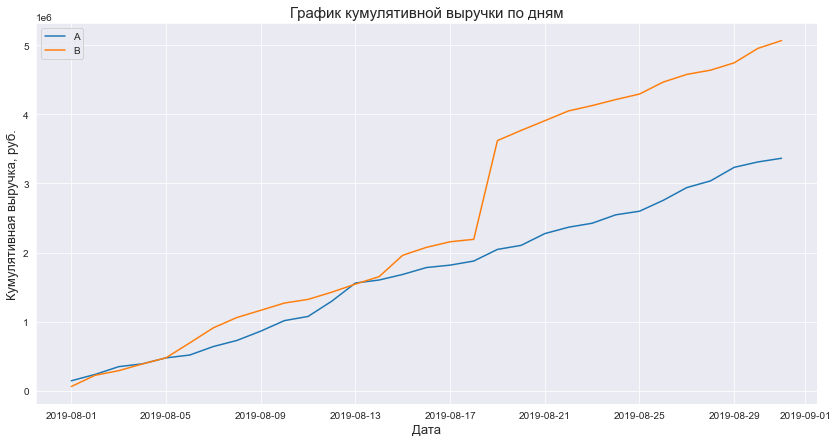

In [33]:
plt.figure(figsize=(14, 7))

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.legend()
plt.title('График кумулятивной выручки по дням', fontsize=15)
plt.xlabel('Дата', fontsize=13)
plt.ylabel('Кумулятивная выручка, руб.', fontsize=13)

cumulative_revenue_by_day_graph = plt.gcf()

Почти на всем времени A/B-теста по кумулятивной выручке лидировала группа B. До 13 августа преимущество было небольшим, но затем разрыв стал увеличиваться.

Также у группы B есть скачок в показателе с 18 по 19 августа. Он может указывать на всплеск числа заказов либо на появлении очень дорогих заказов. Проанализируем такие выбросы позже.

#### Кумулятивный средний чек по группам

Построим графики среднего чека по группам — разделим кумулятивную выручку на кумулятивное число заказов.

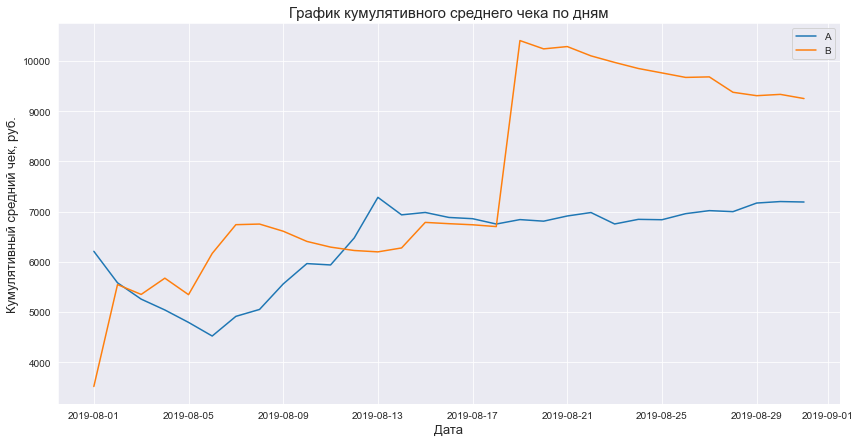

In [34]:
plt.figure(figsize=(14, 7))

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')

plt.legend()
plt.title('График кумулятивного среднего чека по дням', fontsize=15)
plt.xlabel('Дата', fontsize=13)
plt.ylabel('Кумулятивный средний чек, руб.', fontsize=13)

cumulative_avg_check_by_day_graph = plt.gcf()

По кумулятивному среднему чеку группа B тоже обходит группу A. Однако здесь значимое различие появляется с 18 августа, когда чек группу B резко подскакивает. Мы исследуем эту аномалию позже.

Можно сказать, что средний чек группы A установился. У группы B он падает после скачка: так как это кумулятивная метрика, она стремиться к равновесному значению после возникновения единичной аномалии. Поэтому нужно больше времени, чтобы она подошла к 
устойчивому уровню.

#### Относительное изменение кумулятивного среднего чека

Перед построеним графика относительного изменения кумулятивного среднего чека соберем данные о группах в одном датафрейме.

In [35]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB,
                                                   left_on='date', right_on='date',
                                                   how='left', suffixes=['_a', '_b'])

mergedCumulativeRevenue.head()

,date,revenue_a,orders_a,revenue_b,orders_b
0,2019-08-01,142779,23,59758,17
1,2019-08-02,234381,42,221801,40
2,2019-08-03,346854,66,288850,54
3,2019-08-04,388030,77,385740,68
4,2019-08-05,474413,99,475648,89


In [36]:
relations_of_cum_avg_check = ((mergedCumulativeRevenue['revenue_b'] / mergedCumulativeRevenue['orders_b']) / 
                              (mergedCumulativeRevenue['revenue_a'] / mergedCumulativeRevenue['orders_a']) - 1)

relations_of_cum_avg_check.head()

0   -0.433747
1   -0.006357
2    0.017831
3    0.125670
4    0.115255
dtype: float64

Теперь можно строить графики. Добавим горизонтальную ось методом `axhline()`.

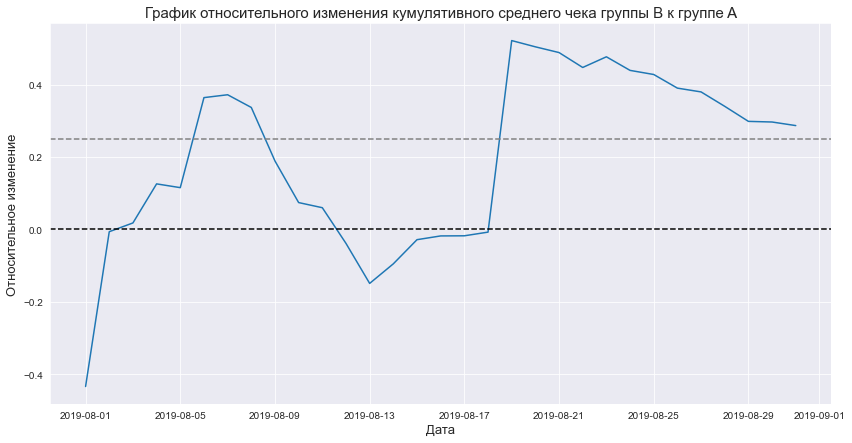

In [37]:
plt.figure(figsize=(14, 7))
plt.plot(mergedCumulativeRevenue['date'], relations_of_cum_avg_check)

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.25, color='grey', linestyle='--')

plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A', fontsize=15)
plt.xlabel('Дата', fontsize=13)
plt.ylabel('Относительное изменение', fontsize=13)

relations_of_cum_avg_check_graph = plt.gcf()

Группа B почти на всем времени теста обходит группу A. При этом есть резкие изменения в районе 7 и 18 августа. Это еще одно подтверждение предположения о том, что в выборках есть выбросы. После скачка 18 августа различие падает, и, хотя последние два дня падение замедлилось, нельзя с уверенностью сказать, что оно остановилось.

#### Кумулятивная конверсия

Проанализируем график кумулятивной конверсии. Чтобы построить его, добавим в `cumulativeData` столбец с конверсией, а затем сохраним данные о группах в разные таблицы. 

In [38]:
cumulativeData['conversion'] = cumulativeData['buyers']/cumulativeData['visitors']
cumulativeData.head()

,date,group,orders,buyers,revenue,visitors,conversion
0,2019-08-01,A,23,19,142779,719,0.026426
1,2019-08-01,B,17,17,59758,713,0.023843
2,2019-08-02,A,42,36,234381,1338,0.026906
3,2019-08-02,B,40,39,221801,1294,0.030139
4,2019-08-03,A,66,60,346854,1845,0.032520


In [39]:
cumulativeDataA = cumulativeData.query('group == "A"')
cumulativeDataB = cumulativeData.query('group == "B"')

Построим графики и зададим для них масштаб осей.

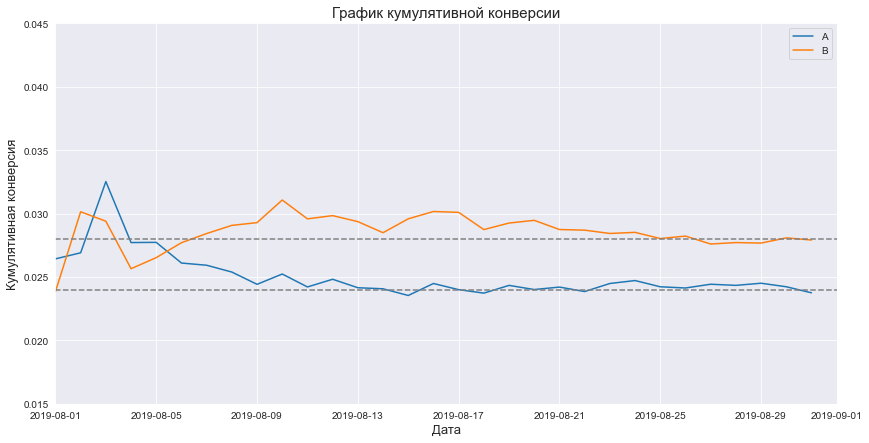

In [40]:
plt.figure(figsize=(14, 7))

plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.axhline(y=0.028, color='grey', linestyle='--')
plt.axhline(y=0.024, color='grey', linestyle='--')

plt.legend()
plt.axis([pd.to_datetime('2019-08-01'), pd.to_datetime('2019-09-01'), 0.015, 0.045]) 
plt.title('График кумулятивной конверсии', fontsize=15)
plt.xlabel('Дата', fontsize=13)
plt.ylabel('Кумулятивная конверсия', fontsize=13)

cumulative_conversion_graph = plt.gcf()

Мы изменили масштаб графика, чтобы было видно, что абсолютное значение колебания в начале и в конце теста не слишком большое: от 2,5% до 3,3% — и что конверсия установилась около среднего значения.

В начале эксперемента группы показывали похожую динамику, и контрольная группа A даже обгоняла тестовую группу B пару-тройку дней. Однако в конце первой недели графики кумулятивных конверсий пересеклись. После этого группа A продолжила плавное падение до среднего значения в 2,4%. Кумулятивная конверсия тестовой группы B установилась в районе 2,7%.

#### Относительное изменение кумулятивной конверсии

Для построения графика относительного изменения кумулятивной конверсии объединим датафреймы с конверсиями групп.

In [41]:
mergedCumulativeConversions = (cumulativeDataA[['date','conversion']]
                               .merge(cumulativeDataB[['date','conversion']],
                                      left_on='date', right_on='date', how='left',
                                      suffixes=['_a', '_b']))

mergedCumulativeConversions.head()

,date,conversion_a,conversion_b
0,2019-08-01,0.026426,0.023843
1,2019-08-02,0.026906,0.030139
2,2019-08-03,0.032520,0.029395
3,2019-08-04,0.027713,0.025651
4,2019-08-05,0.027728,0.026524


Также посчитаем относительное изменение кумулятивной конверсии группы B к группе A.

In [42]:
mergedCumulativeConversions['relative_change'] = (mergedCumulativeConversions['conversion_b'] /
                                                  mergedCumulativeConversions['conversion_a'] - 1)

mergedCumulativeConversions.head()

,date,conversion_a,conversion_b,relative_change
0,2019-08-01,0.026426,0.023843,-0.097734
1,2019-08-02,0.026906,0.030139,0.120170
2,2019-08-03,0.032520,0.029395,-0.096090
3,2019-08-04,0.027713,0.025651,-0.074397
4,2019-08-05,0.027728,0.026524,-0.043392


Посмотрим на график.

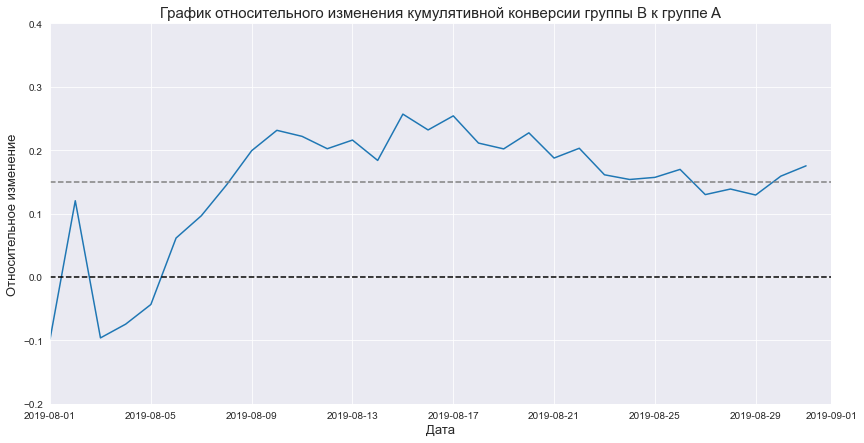

In [43]:
plt.figure(figsize=(14, 7))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['relative_change'])

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.15, color='grey', linestyle='--')
plt.axis([pd.to_datetime('2019-08-01'), pd.to_datetime('2019-09-01'), -0.2, 0.4]) 

plt.title('График относительного изменения кумулятивной конверсии группы B к группе A', fontsize=15)
plt.xlabel('Дата', fontsize=13)
plt.ylabel('Относительное изменение', fontsize=13)

cum_conversion_relative_change_graph = plt.gcf()

С конца первой недели группа B обходит A. В высшей точке графика ее конверсия на 25% больше, чем у группы A. Однако к концу теста ее преимущество уменьшилось до 15%.

[К содержанию](#Содержание)

### Количество заказов по пользователям<a name="Количество-заказов-по-пользователям"></a>

#### Точечный график количества заказов по пользователям

Чтобы оценить, сколько заказов делает один пользователь, построим точечный график количества заказов по пользователям. Подготовим данные для него: подсчитаем количество заказов по пользователям и посмотрим на результат.

In [44]:
orders_by_users = (orders
                   .drop(['date', 'revenue'], axis=1)
                   .groupby('visitor_id', as_index=False)
                   .agg({'transaction_id': 'nunique',
                         'group':'max'}))
orders_by_users.columns = ['visitor_id', 'orders', 'group']

orders_by_users.head()

,visitor_id,orders,group
0,5114589,1,B
1,6958315,1,B
2,11685486,1,A
3,39475350,1,B
4,47206413,1,B


Построим точечную диаграмму числа заказов на одного пользователя:

Text(0, 0.5, 'Число заказов, шт.')

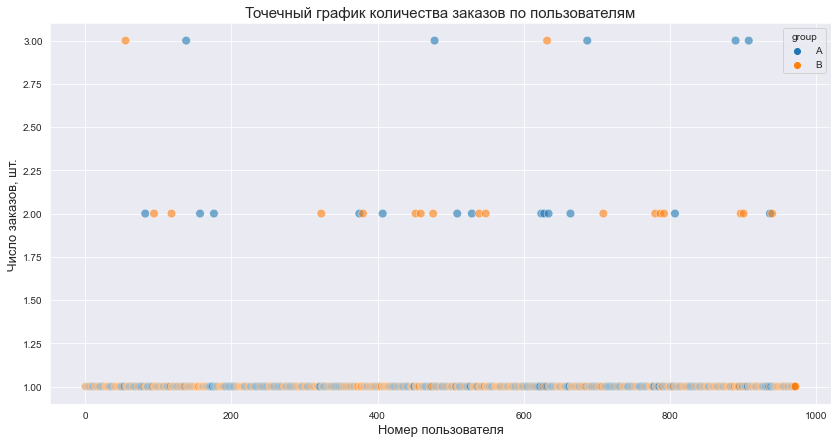

In [45]:
x_values = pd.Series(range(0,len(orders_by_users)))

plt.figure(figsize=(14, 7))
sns.scatterplot(x=x_values, y=orders_by_users['orders'],
                hue=orders_by_users['group'], hue_order=['A', 'B'],
                alpha=0.6, s=75)

plt.title('Точечный график количества заказов по пользователям', fontsize=15)
plt.xlabel('Номер пользователя', fontsize=13)
plt.ylabel('Число заказов, шт.', fontsize=13)

Большинство пользователей делают 1 заказ и довольно много совершают две покупки. Их точная доля не ясна — непонятно, считать их аномалиями или нет. Узнаем в следующем пункте.

#### 95-й и 99-й перцентили количества заказов для определения выбросов

Посчитаем выборочные перцентили количества заказов на одного пользователя:

In [46]:
orders_percentile = np.percentile(orders_by_users['orders'], [95, 99])

print('95 перцентиль: ', orders_percentile[0])
print('99 перцентиль: ', orders_percentile[1])

95 перцентиль:  1.0
99 перцентиль:  2.0


Не более 5% пользователей оформляли больше 1 заказа. И только 1% пользователей заказывали 2 и более раз.  
Будем считать аномальными пользователей, которые сделали от 3 заказов.

### Количество заказов по стоимости<a name="Количество-заказов-по-стоимости"></a>

#### Точечный график стоимостей заказов

Построим точечный график стоимостей заказов. Для него нам не нужно готовить отдельный датафрейм — нужные данные есть в `orders`.

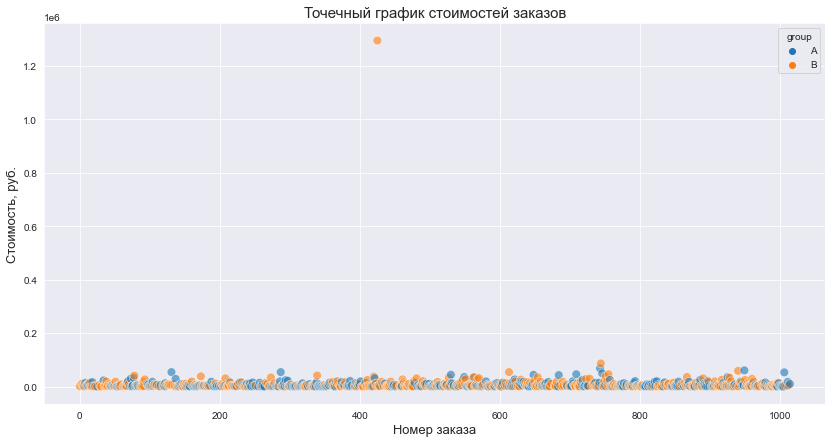

In [47]:
x_values = pd.Series(range(0,len(orders['revenue'])))

plt.figure(figsize=(14, 7))
sns.scatterplot(x=x_values, y=orders['revenue'],
                hue=orders['group'], hue_order=['A', 'B'],
                alpha=0.6, s=75)

plt.title('Точечный график стоимостей заказов', fontsize=15)
plt.xlabel('Номер заказа', fontsize=13)
plt.ylabel('Стоимость, руб.', fontsize=13)

orders_scatter_graph = plt.gcf()

График получился неудачным, потому что один выброс испортил его масштаб. Найдем его.

In [48]:
orders.query('revenue > 10**6')

,transaction_id,visitor_id,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B


Это же подтверждение нашего предположения о том, что кумулятивные выручка и средний чек в группе B скакнули из-за аномально большого заказа! (Дата заказа совпадает со скачком.)

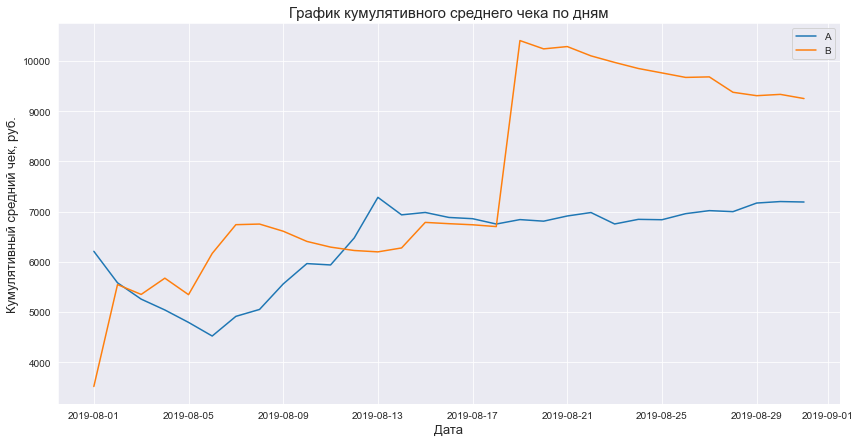

In [49]:
cumulative_avg_check_by_day_graph

Посмотрим поближе на нижнюю часть графика, чтобы лучше разглядеть «нормальные» заказы. 

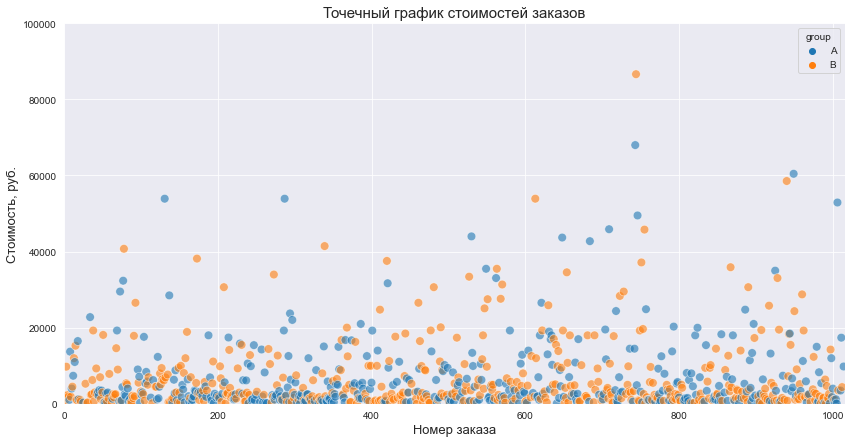

In [50]:
x_values = pd.Series(range(0,len(orders['revenue'])))

plt.figure(figsize=(14, 7))
sns.scatterplot(x=x_values, y=orders['revenue'],
                hue=orders['group'], hue_order=['A', 'B'],
                alpha=0.6, s=75)
plt.axis([0, len(x_values), 0, 100000]) 

plt.title('Точечный график стоимостей заказов', fontsize=15)
plt.xlabel('Номер заказа', fontsize=13)
plt.ylabel('Стоимость, руб.', fontsize=13)

orders_scatter_no_outlier_graph = plt.gcf()

Сумма большинства заказов не превышает 20 тысяч рублей. Также довольно много заказов в диапазоне от 20 до 40 тысяч рублей. Пока мы не можем сказать, какие из них являются выбросами. Определим это на следующем этапе.

#### 95-й и 99-й перцентили стоимости заказов для определения выбрсов

Найдем 95-й и 99-й перцентили стоимости заказов, чтобы выбрать границу для определения аномальных заказов.

In [51]:
revenues_percentiles = np.percentile(orders['revenue'], [95, 99])

print('95 перцентиль: ', round(revenues_percentiles[0]))
print('99 перцентиль: ', round(revenues_percentiles[1]))

95 перцентиль:  26785
99 перцентиль:  53904


Сумма 5% заказов превышает или равна 26,8 тысячам рублей, а самый дорогой 1% заказов начинается почти с 54 тысяч.  
Будем считать аномалиями заказы дороже 40 тысяч. Так мы уберем от 1% до 5% пользователей с дорогими заказами.

[К содержанию](#Содержание)

### Избавление от выбросов<a name="Избавление-от-выбросов"></a>

Мы решили, что будем считать аномальными пользователей, которые сделали от 3 заказов, и заказы дороже 40 тысяч.

#### Аномальные покупатели

Сначала найдем аномальных покупателей.

In [52]:
abnormal_buyers = (orders
                   .groupby('visitor_id', as_index=False)
                   .agg({'transaction_id':'count', 'group':'max'})
                   .query('transaction_id >= 3')
                   .reset_index(drop=True))
abnormal_buyers

,visitor_id,transaction_id,group
0,249864742,3,B
1,611059232,3,A
2,2108163459,3,A
3,2742574263,3,B
4,2988190573,3,A
5,3908431265,3,A
6,3967698036,3,A


Таких всего семь. Удалим их из таблицы с заказами.

In [53]:
abnormal_buyers_ids = abnormal_buyers['visitor_id'].values
abnormal_buyers_ids

array([ 249864742,  611059232, 2108163459, 2742574263, 2988190573,
       3908431265, 3967698036])

In [54]:
orders = orders.query('visitor_id not in @abnormal_buyers_ids')

Убедимся, что аномальные пользователи исчезли.

In [55]:
(orders
 .groupby('visitor_id', as_index=False)
 .agg({'transaction_id':'count', 'group':'max'})
 .query('transaction_id >= 3'))

,visitor_id,transaction_id,group


#### Аномальные заказы

Теперь избавимся от аномально дорогих заказов. Напомним, что на основе точечной диаграммы заказов и 95 и 99 перцентилей мы решили, что будем считать аномальными заказы дороже 40 тысяч. Найдем их.

In [56]:
abnormal_orders = orders.query('revenue >= 40000').reset_index(drop=True)
abnormal_orders.head()

,transaction_id,visitor_id,date,revenue,group
0,773663763,3288820196,2019-08-16,40740,B
1,3163614039,2254586615,2019-08-22,53904,A
2,587872075,2254456485,2019-08-24,53904,A
3,2216192667,834731816,2019-08-25,41450,B
4,590470918,1920142716,2019-08-19,1294500,B


In [57]:
abnormal_orders_ids = abnormal_orders['transaction_id'].values
abnormal_orders_ids[:5]

array([ 773663763, 3163614039,  587872075, 2216192667,  590470918])

In [58]:
print(f'Число аномальных заказов: {len(abnormal_orders_ids)}')

Число аномальных заказов: 23


Удалим аномальные заказы и убедимся, что они исчезли.

In [59]:
orders = orders.query('revenue < 40000')
orders.query('revenue >= 40000')

,transaction_id,visitor_id,date,revenue,group


#### Расчет кумулятивных метрик по чистым данным

Соберем таблицу с кумулятивными метриками аналагично тому, как мы делали это в начале анализа. Только теперь мы будем использовать очищенные данные для расчетов.

In [60]:
datesGroupsClean = orders[['date','group']].drop_duplicates(ignore_index=True)
datesGroupsClean.head()

,date,group
0,2019-08-15,B
1,2019-08-15,A
2,2019-08-16,A
3,2019-08-16,B
4,2019-08-01,A


In [61]:
ordersAggregatedClean = (datesGroupsClean
                         .apply(axis=1, func=get_cumulative_orders_data)
                         .sort_values(by=['date','group']))

ordersAggregatedClean.head()

,date,group,transaction_id,visitor_id,revenue
4,2019-08-01,A,18,17,112340
5,2019-08-01,B,17,17,59758
12,2019-08-02,A,36,34,202252
11,2019-08-02,B,40,39,221801
17,2019-08-03,A,60,58,314725


In [62]:
cumulativeDataClean = ordersAggregatedClean.merge(visitorsAggregated,
                                                  left_on=['date', 'group'],
                                                  right_on=['date', 'group'])

cumulativeDataClean.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
cumulativeDataClean.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,18,17,112340,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,36,34,202252,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,60,58,314725,1845


In [63]:
cumulativeDataClean['conversion'] = cumulativeDataClean['buyers']/cumulativeDataClean['visitors']
cumulativeDataClean['avg_check'] = cumulativeDataClean['revenue']/cumulativeDataClean['orders']
cumulativeDataClean.head()

,date,group,orders,buyers,revenue,visitors,conversion,avg_check
0,2019-08-01,A,18,17,112340,719,0.023644,6241.111111
1,2019-08-01,B,17,17,59758,713,0.023843,3515.176471
2,2019-08-02,A,36,34,202252,1338,0.025411,5618.111111
3,2019-08-02,B,40,39,221801,1294,0.030139,5545.025000
4,2019-08-03,A,60,58,314725,1845,0.031436,5245.416667


In [64]:
cumulativeDataAClean = cumulativeDataClean.query('group == "A"')
cumulativeDataBClean = cumulativeDataClean.query('group == "B"')

cumulativeDataAClean.head()

,date,group,orders,buyers,revenue,visitors,conversion,avg_check
0,2019-08-01,A,18,17,112340,719,0.023644,6241.111111
2,2019-08-02,A,36,34,202252,1338,0.025411,5618.111111
4,2019-08-03,A,60,58,314725,1845,0.031436,5245.416667
6,2019-08-04,A,71,69,355901,2562,0.026932,5012.690141
8,2019-08-05,A,93,90,442284,3318,0.027125,4755.741935


[К содержанию](#Содержание)

### Графики среднего чека и конверсии по очищенным данным<a name="Графики-среднего-чека-и-конверсии-по-очищенным-данным"></a>

Посмотрим, как удаление выбросов повлияло на наши метрики.

#### Средний чек

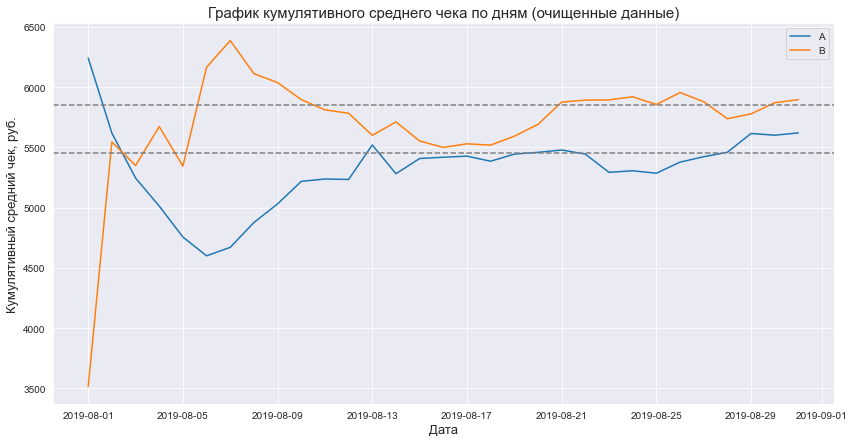

In [65]:
plt.figure(figsize=(14, 7))

plt.plot(cumulativeDataAClean['date'], cumulativeDataAClean['avg_check'], label='A')
plt.plot(cumulativeDataBClean['date'], cumulativeDataBClean['avg_check'], label='B')
plt.axhline(y=5450, color='grey', linestyle='--')
plt.axhline(y=5850, color='grey', linestyle='--')

plt.legend()
plt.title('График кумулятивного среднего чека по дням (очищенные данные)', fontsize=15)
plt.xlabel('Дата', fontsize=13)
plt.ylabel('Кумулятивный средний чек, руб.', fontsize=13)

cumulative_avg_check_by_day_clean_graph = plt.gcf()

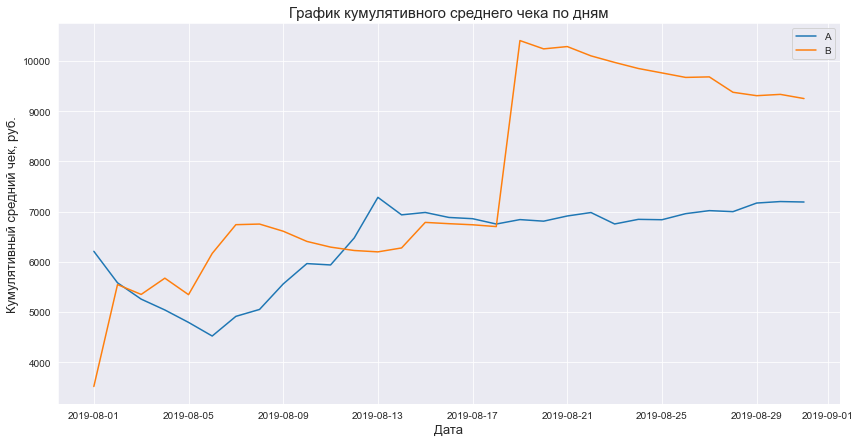

In [66]:
cumulative_avg_check_by_day_graph

После очистки данных график кумулятивного среднего чека сильно изменился. Теперь тестовая группа показывает лучшую динамику уже сначала теста.

Также можно сказать, что к концу эксперимента средний чек установился в обеих группах.

#### Конверсия

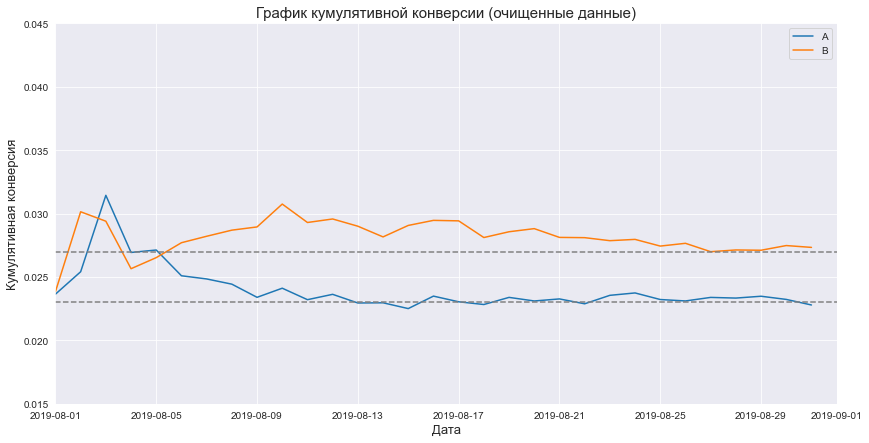

In [67]:
plt.figure(figsize=(14, 7))

plt.plot(cumulativeDataAClean['date'], cumulativeDataAClean['conversion'], label='A')
plt.plot(cumulativeDataBClean['date'], cumulativeDataBClean['conversion'], label='B')
plt.axhline(y=0.027, color='grey', linestyle='--')
plt.axhline(y=0.023, color='grey', linestyle='--')

plt.legend()
plt.axis([pd.to_datetime('2019-08-01'), pd.to_datetime('2019-09-01'), 0.015, 0.045]) 
plt.title('График кумулятивной конверсии (очищенные данные)', fontsize=15)
plt.xlabel('Дата', fontsize=13)
plt.ylabel('Кумулятивная конверсия', fontsize=13)

cumulative_conversion_clean_graph = plt.gcf()

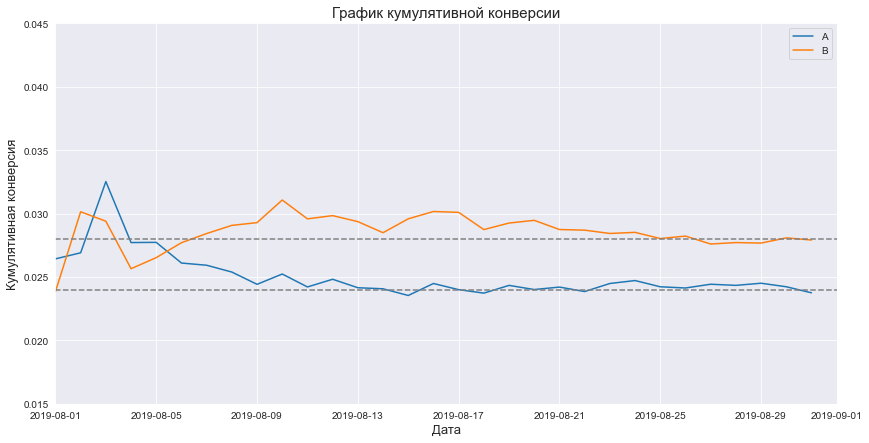

In [68]:
cumulative_conversion_graph

На первый взгляд кажется, что графики кумулятивных конверсий в группах не изменились. Однако это не совсем так: хоть формы и остались прежними, обе группы потеряли по 0,1 процентного пункта. 

#### Относительное изменение конверсии

In [69]:
mergedCumulativeConversionsClean = (cumulativeDataClean.query('group=="A"')[['date','conversion']]
                                    .merge(cumulativeDataClean.query('group=="B"')[['date','conversion']],
                                           left_on='date', right_on='date', how='left',
                                           suffixes=['_a', '_b']))

mergedCumulativeConversionsClean.head()

,date,conversion_a,conversion_b
0,2019-08-01,0.023644,0.023843
1,2019-08-02,0.025411,0.030139
2,2019-08-03,0.031436,0.029395
3,2019-08-04,0.026932,0.025651
4,2019-08-05,0.027125,0.026524


In [70]:
mergedCumulativeConversionsClean['relative_change'] = (mergedCumulativeConversionsClean['conversion_b'] /
                                                       mergedCumulativeConversionsClean['conversion_a'] - 1)

mergedCumulativeConversionsClean.head()

,date,conversion_a,conversion_b,relative_change
0,2019-08-01,0.023644,0.023843,0.008415
1,2019-08-02,0.025411,0.030139,0.186062
2,2019-08-03,0.031436,0.029395,-0.064921
3,2019-08-04,0.026932,0.025651,-0.047568
4,2019-08-05,0.027125,0.026524,-0.022134


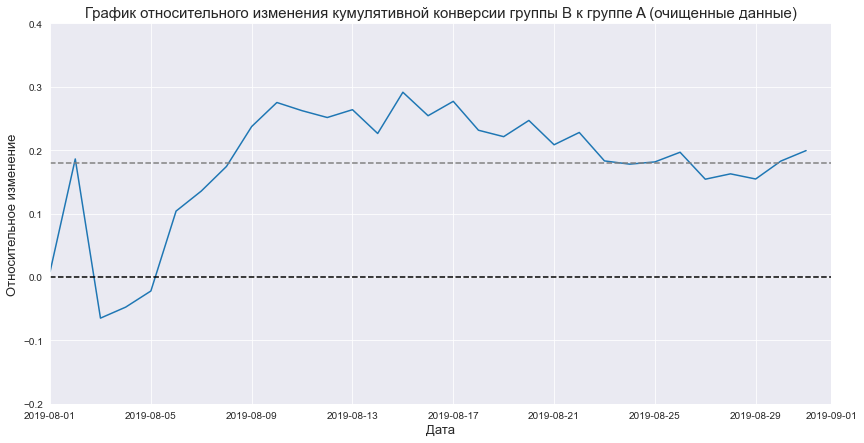

In [71]:
plt.figure(figsize=(14, 7))
plt.plot(mergedCumulativeConversionsClean['date'], mergedCumulativeConversionsClean['relative_change'])

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.18, color='grey', linestyle='--')
plt.axis([pd.to_datetime('2019-08-01'), pd.to_datetime('2019-09-01'), -0.2, 0.4]) 

plt.title('График относительного изменения кумулятивной конверсии группы B к группе A (очищенные данные)', fontsize=15)
plt.xlabel('Дата', fontsize=13)
plt.ylabel('Относительное изменение', fontsize=13)

cum_conversion_relative_change_clean_graph = plt.gcf()

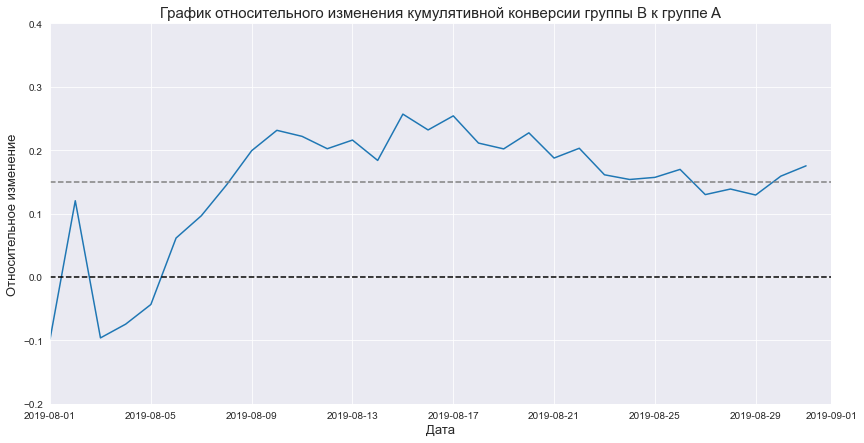

In [72]:
cum_conversion_relative_change_graph

График относительно изменения кумулятивной конверсии тоже почти не изменился.

[К содержанию](#Содержание)

### Расчет статзначимости различий<a name="Расчет-статзначимости-различий"></a>

#### Различия в конверсиях

Посмотрим на кумулятивные метрики для каждой группы в последний день эксперимента. 

In [73]:
cumulativeDataClean.query('date == "2019-08-31"')

,date,group,orders,buyers,revenue,visitors,conversion,avg_check
60,2019-08-31,A,439,427,2467204,18736,0.022790,5620.054670
61,2019-08-31,B,533,517,3142395,18916,0.027331,5895.675422


Рассчитаем статзначимость различий в конверсиях с помощью z-критерия для двух долей.

- Нулевая гипотеза: конверсии в группах равны.
- Альтернативная гипотеза: конверсии в группах различаются.

Возьмем 5% уровень значимости.

In [74]:
alpha = 0.05
stat, p_value = proportions_ztest([427, 517], [18736, 18916])    

print(f'p-значение: {p_value:.5f}')

if p_value < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.00483
Отвергаем нулевую гипотезу


Конверсии в контрольной и тестовой группах статзначимо различаются. В контрольной группе она равна 2,28%, а в тестовой — 2,73%. То есть тестируемый нами блок рекомендаций действительно увеличивает конверсию.

#### Различия в среднем чеке

Графики кумулятивного среднего чеки показали, что у группы B средний чек больше, чем у группы A. Посчитаем статистическую значимость этого различия.

Сохраним чеки групп в две переменные `revenue_a` и `revenue_b`. 

In [75]:
revenue_a = orders.query('group=="A"')['revenue']
revenue_b = orders.query('group=="B"')['revenue']

Чтобы выбрать способ проверки статистической значимости, посмотрим на распределения числа заказов по размерам чеков в группах.

[Text(0.5, 0, 'Размер чека, руб.'),
 Text(0, 0.5, 'Количество заказов, шт.'),
 Text(0.5, 0, 'Размер чека, руб.'),
 Text(0, 0.5, 'Количество заказов, шт.')]

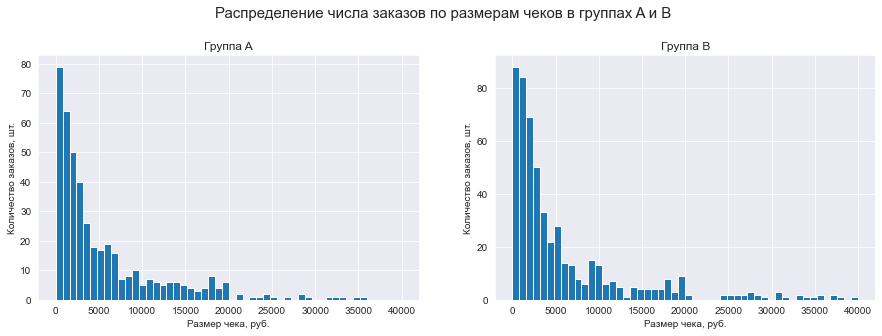

In [76]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4.5))
fig.suptitle('Распределение числа заказов по размерам чеков в группах A и B', y=1.03, fontsize=15)

revenue_a.to_frame().plot(kind='hist', bins=50, range=(0, 40000), y='revenue', title='Группа A', ax=ax1, legend=False)
revenue_b.to_frame().plot(kind='hist', bins=50, range=(0, 40000), y='revenue', title='Группа B', ax=ax2, legend=False)

plt.setp([ax1, ax2], xlabel='Размер чека, руб.', ylabel='Количество заказов, шт.')

Распределения не нормальные, поэтому для проверки различий в выборках воспользуемся непараметрическим тестом. А именно критерием Манна-Уитни.

- Нулевая гипотеза: различий в среднем чеке нет.
- Альтернативная гипотеза: у группы B средний чек больше.

Возьмем 5% уровень значимости.

In [77]:
alpha = 0.05

results = st.mannwhitneyu(revenue_a, revenue_b, use_continuity=True, alternative='less')
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.49029233089464724
Не получилось отвергнуть нулевую гипотезу


Средний чек в группе B больше на 275 рублей, или почти на 5%, чем в группе A. Но это различие не статзначимо. То есть, скорее всего, мы получили его случайно.

[К содержанию](#Содержание)

## 5. Выводы по результатам теста<a name="5.-Выводы-по-результатам-теста"></a>

**Мы получили некачественные данные:** пользователь мог попасть и в контрольную, и в тестовую группы.

Во время предобработки данных мы обнаружили, что часть покупателей попали и в контрольную, и в тестовую группы. Таких пользователей оказалось меньше 6%. Мы избавились от них, так как посчитали справедливым пожертвовать таким объемом данных ради точности выводов.

Стоит передать информацию об этой неполадке команде, которая собирала для нас данные.

**Тест можно завершать:** можно сказать, что интересующие нас кумулятивные конверсия и средний чек установились у своих средних значений.

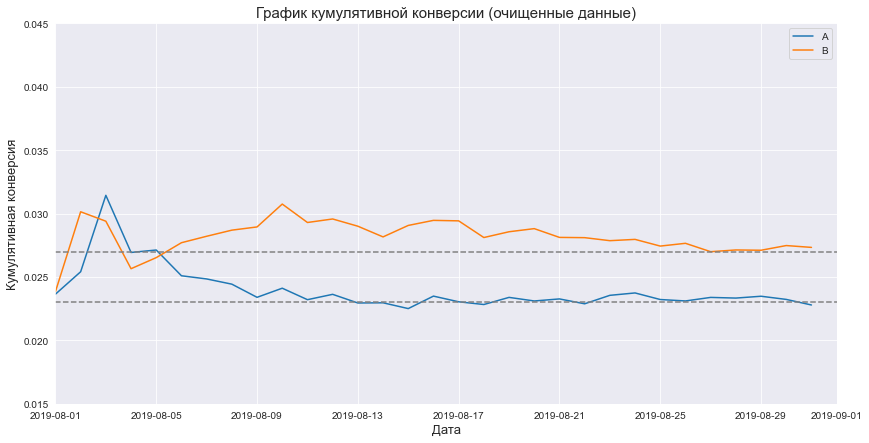

In [78]:
cumulative_conversion_clean_graph

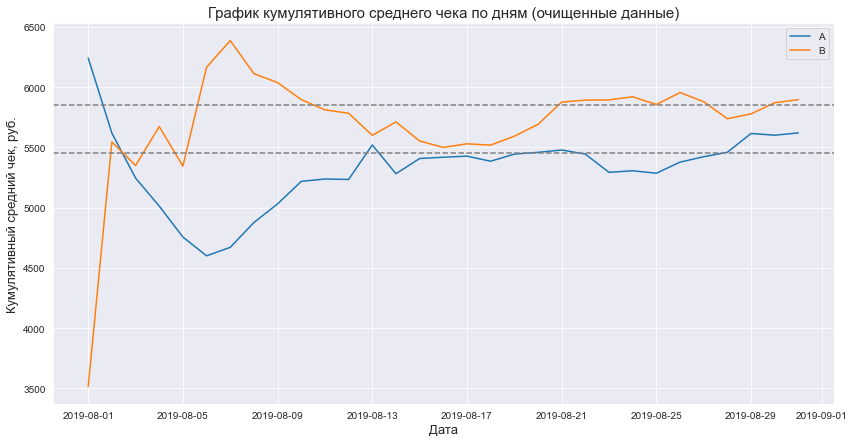

In [79]:
cumulative_avg_check_by_day_clean_graph

**Блок рекомендаций статзначимо увеличивает конверсию в покупку на 20%**

По графикам видно, что и конверсия, и средний чек в тестовой группе больше, чем в контрольной. Мы проверили эти различия на статзначимость, и оказалось, что разница статзначима только у конверсий. Средние чеки, скорее всего, оказались разными случайно.

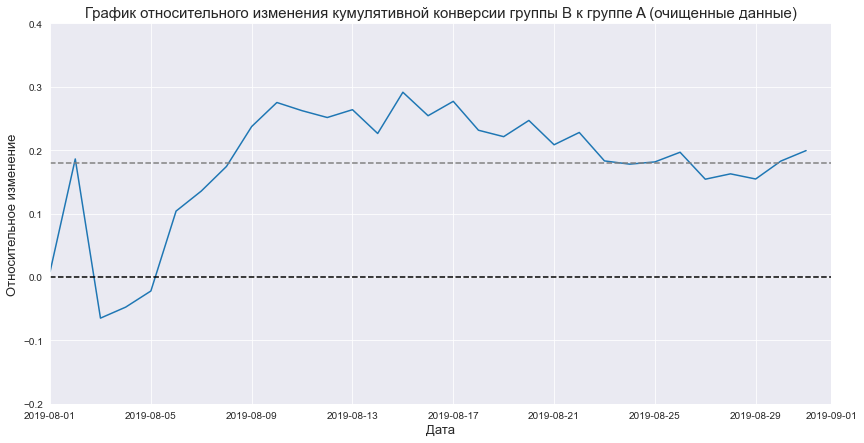

In [80]:
cum_conversion_relative_change_clean_graph

[К содержанию](#Содержание)